# Least Squares GAN

**Overview:**
Generative adversarial networks (GANs) are explored for the application of generating synthetic spectroscopic data. Architectures established in previous work are considered and adapted for the particular spectroscopic data of interest. Least square GANs (LSGANs) are shown to achieve
satisfactory performance by comparing synthetic spectra to genuine data. Synthetic spectra are compared to validation sets not used in training, resulting in nearly identical distributions
that suggest the GAN is not simply memorizing training data.

In this ipnb, I will build and train a LSGAN model to generate fake arpes data.

## 1) Load Data:

**About the Data:**
Angle-resolved photoemission Spectroscopy (ARPES) is a powerful tool to investigate the electronic structure of a material by making use of photoemission effect (a photon-in-electron-out process). The electrons are photoemitted by a pulsed laser beam in an ultra-high vacuum chamber, and their kinetic energy can be calculated by the time-of-flight measurements. By accumulating the photoelectron counts at interested momentum, one can obtain an energy dispersion curve (EDC), which is a plot of photoelectron intensity as a function of binding energy (EB). Hence, a full electronic band
structure of a material can be mapped out by changing the sample rotational angle.

In [1]:
import arpes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

In [2]:
mapFolder, edcStack, trimEDCs = arpes.loadAllData()
shortEDCs = np.array([trimEDCs[i][250:500] for i in range(trimEDCs.shape[0])])

Number of raw map = 21
total data point = 428
trimEDCs.shape = (428, 1693)


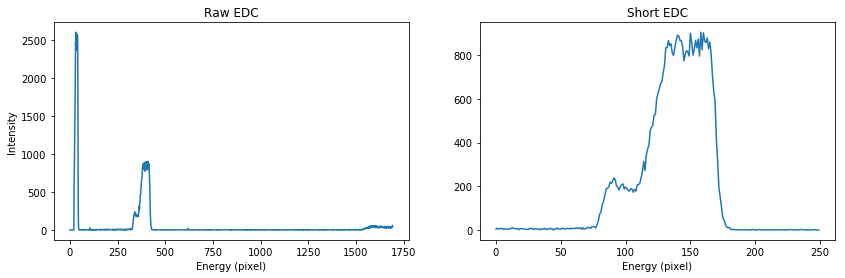

In [3]:
plt.figure(figsize=[14, 4])
plt.subplot(1,2,1)
plt.plot(trimEDCs[420])
plt.title("Raw EDC")
plt.ylabel("Intensity")
plt.xlabel("Energy (pixel)")
plt.subplot(1,2,2)
plt.plot(shortEDCs[420])
plt.title("Short EDC")
plt.xlabel("Energy (pixel)")
plt.show()

In [4]:
def scaleEDC(edc):
    return edc/max(edc)

def scaleAndShiftEDC(edc):
    return (edc/max(edc))-0.5

# Normalize and shift the intensity:
scaleEDCs = np.array([scaleEDC(shortEDCs[i]) for i in range(shortEDCs.shape[0])])
ssEDCs = np.array([scaleAndShiftEDC(shortEDCs[i]) for i in range(shortEDCs.shape[0])])

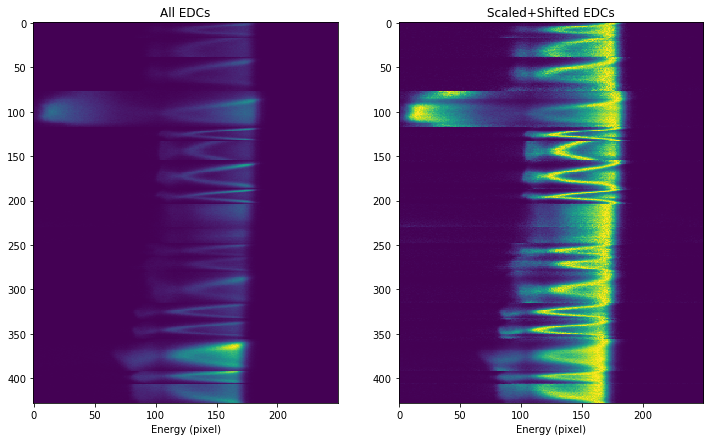

Data matrix shape = (428, 250)


In [5]:
plt.figure(figsize=[12, 7])
plt.subplot(1,2,1)
plt.imshow(shortEDCs, aspect='auto')
plt.title('All EDCs')
plt.xlabel('Energy (pixel)')
plt.subplot(1,2,2)
plt.imshow(ssEDCs, aspect='auto')
plt.title('Scaled+Shifted EDCs')
plt.xlabel('Energy (pixel)')
plt.show()
print("Data matrix shape =", ssEDCs.shape)

## 2) Build LSGAN

In [6]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, Adadelta, SGD

Using TensorFlow backend.


In [90]:
from keras.layers.advanced_activations import Softmax

In [99]:
class LSGAN():
    def __init__(self, opt, loss, info=False):
        self.n_pixel = 250
        self.data_shape = (self.n_pixel,)
        self.opt = opt

        optimizer_map = {'adam':Adam(0.0003, 0.5), 'adadelta':Adadelta(lr=1.0), 'sgd':SGD(lr=0.003)}
        optimizer = optimizer_map[opt]

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator(info)
        self.discriminator.compile(loss=loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator(info)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,)) # This shape needs to match the noise_shape in build_generator. z is a latent variable
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=loss, optimizer=optimizer)

    def build_generator(self, info=False):

        noise_shape = (100,) # for latent variable z

        model = Sequential()

        model.add(Dense(1024, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.data_shape), activation='tanh'))
        model.add(Reshape(self.data_shape))

        if info:
            model.summary()

        noise = Input(shape=noise_shape)
        f_datum = model(noise) # This is fake data: g(z)

        return Model(noise, f_datum)

    def build_discriminator(self, info=False):
        data_shape = (self.n_pixel, )

        model = Sequential()

        model.add(Dense(512, input_shape=data_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        # model.add(Softmax())
        model.add(Dense(1))
        if info:
            model.summary()

        datum = Input(shape=data_shape)
        validity = model(datum)

        return Model(datum, validity)

    def train(self, X_train, epochs, batch_size=100, sample_interval=100):
        # batch_size=128, sample_interval=50
        
        X_train = X_train
        self.batch_size = batch_size

        half_batch = int(batch_size / 2)

        self.d_loss = np.zeros(epochs)
        self.g_loss = np.zeros(epochs)
        self.d_acc = np.zeros(epochs)
        for epoch in range(epochs):

            ##### TRAIN DISCRIMINATOR #####

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            data = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            fake_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(data, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            self.d_loss[epoch] = d_loss[0]
            self.d_acc[epoch] = d_loss[1]
            

            ##### TRAIN GENERATOR #####

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            self.g_loss[epoch] = g_loss

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                self.sample_images(epoch)
                if epoch % (2*sample_interval) == 0:
                    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                

    def sample_images(self, epoch):
        r, c = 2, 2
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].plot(gen_imgs[cnt])
                cnt += 1
        # fig.savefig("images_{}/batch/arpes_{}.png".format(self.opt, epoch))
        fig.savefig("images_{}/batch{}/arpes_{}.png".format(self.opt, self.batch_size, epoch))
        plt.close()

        
def plotGANprocess(gan, stepsize):
    x = np.arange(0, len(gan.d_acc), stepsize)
    y = np.array([np.mean(gan.d_acc[i*stepsize:(i+1)*stepsize]) for i in range(len(x))])
    plt.figure(figsize=[12, 5])
    plt.subplot(1,2,1)
    plt.plot(x, gan.d_acc[::stepsize], label="ith", c='g')
    plt.plot(x, y, label='mean', c='y')
    plt.axhline(y=.5, c='r', ls='--')
    plt.xlabel('epoch')
    plt.ylabel('Discrimiator Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x, gan.d_loss[::stepsize], label='Discriminator')
    plt.plot(x, gan.g_loss[::stepsize], label='Generator')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Train on Normalized Data

In [17]:
gan_scale_adam = LSGAN('adam')
gan_scale_adam.train(scaleEDCs, epochs=25000, batch_size=50, sample_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.378863, acc.: 50.00%] [G loss: 0.625341]
500 [D loss: 0.034938, acc.: 98.00%] [G loss: 1.438944]
1000 [D loss: 0.049666, acc.: 92.00%] [G loss: 0.888726]
1500 [D loss: 0.002172, acc.: 100.00%] [G loss: 1.034939]
2000 [D loss: 0.001483, acc.: 100.00%] [G loss: 1.001139]
2500 [D loss: 0.002117, acc.: 100.00%] [G loss: 1.003286]
3000 [D loss: 0.001668, acc.: 100.00%] [G loss: 1.021438]
3500 [D loss: 0.002100, acc.: 100.00%] [G loss: 0.969470]
4000 [D loss: 0.001550, acc.: 100.00%] [G loss: 1.058277]
4500 [D loss: 0.001196, acc.: 100.00%] [G loss: 0.962554]
5000 [D loss: 0.000504, acc.: 100.00%] [G loss: 1.005711]
5500 [D loss: 0.004167, acc.: 100.00%] [G loss: 0.985218]
6000 [D loss: 0.001173, acc.: 100.00%] [G loss: 0.995722]
6500 [D loss: 0.003380, acc.: 100.00%] [G loss: 0.985273]
7000 [D loss: 0.010900, acc.: 100.00%] [G loss: 0.996238]
7500 [D loss: 0.001133, acc.: 100.00%] [G loss: 1.015929]
8000 [D loss: 0.000343, acc.: 100.00%] [G loss: 1.009011]
8500 [D loss: 0.00017

Adam optimizer. Epoch = 25000


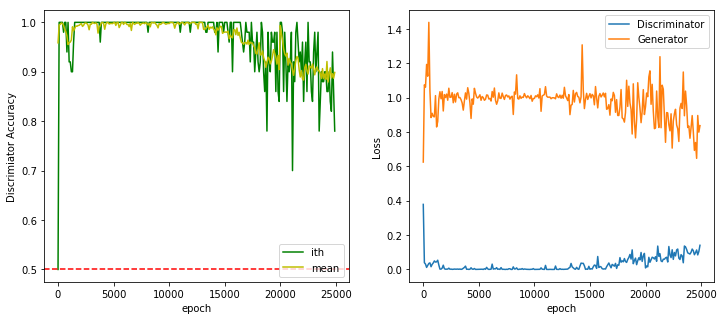

In [45]:
print('Adam optimizer. Epoch = 25000')
plotGANprocess(gan_scale_adam, 100)

## Train on Normalized + Shift Data

### Using Adam Optimizer

In [36]:
gan_adam = LSGAN('adam')
gan_adam.train(ssEDCs, epochs=25000, batch_size=50, sample_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.201275, acc.: 50.00%] [G loss: 0.478935]
500 [D loss: 0.048536, acc.: 92.00%] [G loss: 1.036696]
1000 [D loss: 0.063268, acc.: 88.00%] [G loss: 1.164552]
1500 [D loss: 0.107180, acc.: 82.00%] [G loss: 0.852225]
2000 [D loss: 0.024174, acc.: 100.00%] [G loss: 0.941940]
2500 [D loss: 0.088526, acc.: 86.00%] [G loss: 0.824668]
3000 [D loss: 0.062723, acc.: 94.00%] [G loss: 0.752644]
3500 [D loss: 0.284702, acc.: 76.00%] [G loss: 1.047365]
4000 [D loss: 0.198232, acc.: 70.00%] [G loss: 0.933201]
4500 [D loss: 0.165302, acc.: 82.00%] [G loss: 1.172453]
5000 [D loss: 0.177454, acc.: 70.00%] [G loss: 0.632594]
5500 [D loss: 0.215681, acc.: 62.00%] [G loss: 0.577886]
6000 [D loss: 0.155332, acc.: 80.00%] [G loss: 0.663633]
6500 [D loss: 0.225888, acc.: 68.00%] [G loss: 0.545290]
7000 [D loss: 0.208133, acc.: 58.00%] [G loss: 0.439334]
7500 [D loss: 0.187371, acc.: 72.00%] [G loss: 0.603783]
8000 [D loss: 0.203321, acc.: 64.00%] [G loss: 0.534969]
8500 [D loss: 0.177343, acc.: 72.0

Adam optimizer. Epoch = 25000


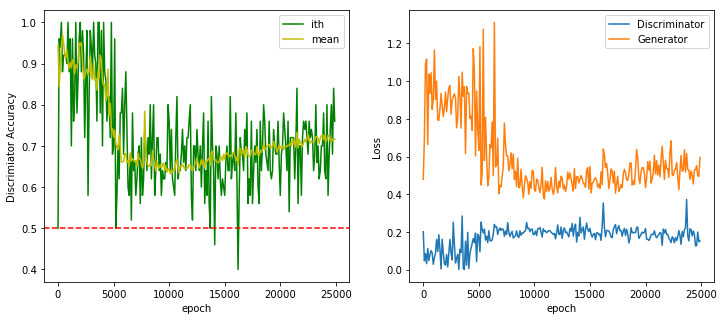

In [46]:
print('Adam optimizer. Epoch = 25000')
plotGANprocess(gan_adam, 100)

### Using SGD Optimizer

In [33]:
gan_sgd = LSGAN('sgd')
gan_sgd.train(ssEDCs, epochs=25000, batch_size=50, sample_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.704453, acc.: 50.00%] [G loss: 0.916124]
500 [D loss: 0.020359, acc.: 100.00%] [G loss: 0.948747]
1000 [D loss: 0.009693, acc.: 100.00%] [G loss: 1.050874]
1500 [D loss: 0.021731, acc.: 100.00%] [G loss: 0.936836]
2000 [D loss: 0.013623, acc.: 100.00%] [G loss: 1.034145]
2500 [D loss: 0.051913, acc.: 92.00%] [G loss: 0.968761]
3000 [D loss: 0.022064, acc.: 100.00%] [G loss: 1.098353]
3500 [D loss: 0.015998, acc.: 100.00%] [G loss: 1.033664]
4000 [D loss: 0.010479, acc.: 100.00%] [G loss: 1.077037]
4500 [D loss: 0.009142, acc.: 100.00%] [G loss: 1.035007]
5000 [D loss: 0.005828, acc.: 100.00%] [G loss: 1.086846]
5500 [D loss: 0.006190, acc.: 100.00%] [G loss: 1.037148]
6000 [D loss: 0.005217, acc.: 100.00%] [G loss: 1.006689]
6500 [D loss: 0.014862, acc.: 100.00%] [G loss: 1.136996]
7000 [D loss: 0.016405, acc.: 100.00%] [G loss: 1.077637]
7500 [D loss: 0.014431, acc.: 100.00%] [G loss: 1.079645]
8000 [D loss: 0.048897, acc.: 98.00%] [G loss: 1.019209]
8500 [D loss: 0.07655

SGD optimizer. Epoch = 25000


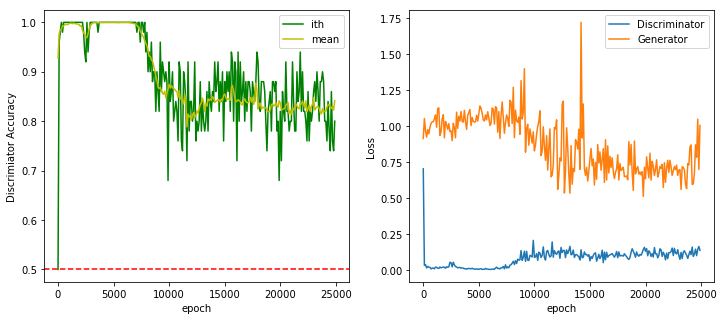

In [47]:
print('SGD optimizer. Epoch = 25000')
plotGANprocess(gan_sgd, 100)

### Using Adadelta Optimizer

In [38]:
gan_ada = LSGAN('adadelta')
gan_ada.train(ssEDCs, epochs=25000, batch_size=50, sample_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_72 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.755862, acc.: 50.00%] [G loss: 0.883237]
500 [D loss: 0.020660, acc.: 100.00%] [G loss: 1.014003]
1000 [D loss: 0.011326, acc.: 100.00%] [G loss: 1.034200]
1500 [D loss: 0.075063, acc.: 100.00%] [G loss: 0.788167]
2000 [D loss: 0.261839, acc.: 54.00%] [G loss: 0.575400]
2500 [D loss: 0.292755, acc.: 56.00%] [G loss: 0.860500]
3000 [D loss: 0.239981, acc.: 60.00%] [G loss: 0.411932]
3500 [D loss: 0.210508, acc.: 70.00%] [G loss: 0.446111]
4000 [D loss: 0.263729, acc.: 60.00%] [G loss: 0.532454]
4500 [D loss: 0.208052, acc.: 66.00%] [G loss: 1.003584]
5000 [D loss: 0.233450, acc.: 56.00%] [G loss: 0.470630]
5500 [D loss: 0.193997, acc.: 76.00%] [G loss: 0.388258]
6000 [D loss: 0.202025, acc.: 66.00%] [G loss: 0.472867]
6500 [D loss: 0.209100, acc.: 62.00%] [G loss: 0.483674]
7000 [D loss: 0.245142, acc.: 52.00%] [G loss: 0.525418]
7500 [D loss: 0.202694, acc.: 76.00%] [G loss: 0.462860]
8000 [D loss: 0.236138, acc.: 58.00%] [G loss: 0.450043]
8500 [D loss: 0.241949, acc.: 46

Adadelta optimizer. Epoch = 25000


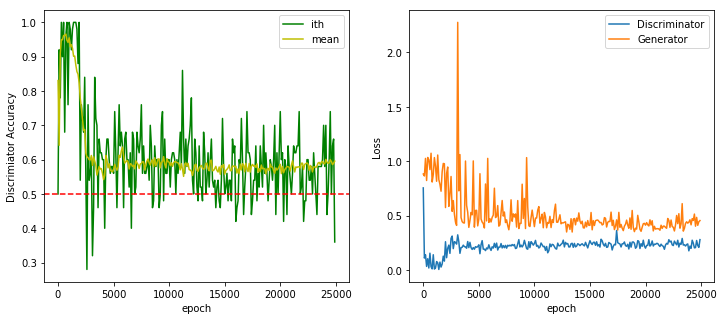

In [48]:
print('Adadelta optimizer. Epoch = 25000')
plotGANprocess(gan_ada, 100)

### Loss function: mean_absolute_error

In [57]:
gan_ada_abs = LSGAN('adadelta', 'mean_absolute_error')
gan_ada_abs.train(ssEDCs, epochs=30000, batch_size=50, sample_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.691874, acc.: 50.00%] [G loss: 1.136657]
500 [D loss: 0.313023, acc.: 82.00%] [G loss: 1.063996]
1000 [D loss: 0.117925, acc.: 100.00%] [G loss: 0.841100]
1500 [D loss: 0.555032, acc.: 66.00%] [G loss: 0.592499]
2000 [D loss: 0.309161, acc.: 76.00%] [G loss: 0.665178]
2500 [D loss: 0.359738, acc.: 80.00%] [G loss: 0.972623]
3000 [D loss: 0.449933, acc.: 60.00%] [G loss: 0.578299]
3500 [D loss: 0.388000, acc.: 64.00%] [G loss: 0.669833]
4000 [D loss: 0.416725, acc.: 62.00%] [G loss: 0.633479]
4500 [D loss: 0.496734, acc.: 54.00%] [G loss: 0.677629]
5000 [D loss: 0.401482, acc.: 66.00%] [G loss: 0.640337]
5500 [D loss: 0.346085, acc.: 68.00%] [G loss: 0.726608]
6000 [D loss: 0.371846, acc.: 68.00%] [G loss: 0.608431]
6500 [D loss: 0.429180, acc.: 56.00%] [G loss: 0.627280]
7000 [D loss: 0.441408, acc.: 60.00%] [G loss: 0.569740]
7500 [D loss: 0.315685, acc.: 80.00%] [G loss: 2.345523]
8000 [D loss: 0.444137, acc.: 56.00%] [G loss: 0.709473]
8500 [D loss: 0.419959, acc.: 60.0

Adadelta optimizer. Loss = mean_absolute_error. Epoch = 20000


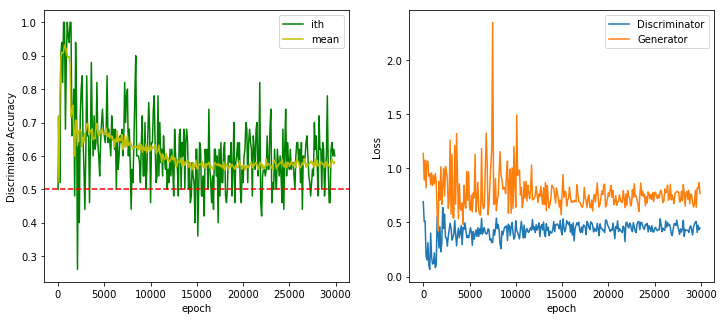

In [58]:
print('Adadelta optimizer. Loss = mean_absolute_error. Epoch = 20000')
plotGANprocess(gan_ada_abs, 100)

### Loss function: logcosh

In [61]:
gan_ada_logcosh = LSGAN('adadelta', 'logcosh')
gan_ada_logcosh.train(ssEDCs, epochs=25000, batch_size=50, sample_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.180799, acc.: 50.00%] [G loss: 0.207984]
500 [D loss: 0.038275, acc.: 98.00%] [G loss: 0.439244]
1000 [D loss: 0.000972, acc.: 100.00%] [G loss: 0.436973]
1500 [D loss: 0.008267, acc.: 100.00%] [G loss: 0.377573]
2000 [D loss: 0.139778, acc.: 42.00%] [G loss: 0.262659]
2500 [D loss: 0.124760, acc.: 62.00%] [G loss: 0.190336]
3000 [D loss: 0.114209, acc.: 44.00%] [G loss: 0.197842]
3500 [D loss: 0.136753, acc.: 26.00%] [G loss: 0.196075]
4000 [D loss: 0.119481, acc.: 46.00%] [G loss: 0.168410]
4500 [D loss: 0.142431, acc.: 38.00%] [G loss: 0.295835]
5000 [D loss: 0.111799, acc.: 60.00%] [G loss: 0.226438]
5500 [D loss: 0.117010, acc.: 56.00%] [G loss: 0.222615]
6000 [D loss: 0.105826, acc.: 58.00%] [G loss: 0.197589]
6500 [D loss: 0.118489, acc.: 38.00%] [G loss: 0.251186]
7000 [D loss: 0.122973, acc.: 44.00%] [G loss: 0.184451]
7500 [D loss: 0.112814, acc.: 46.00%] [G loss: 0.200455]
8000 [D loss: 0.110713, acc.: 60.00%] [G loss: 0.217326]
8500 [D loss: 0.109107, acc.: 58.

Adadelta optimizer. Loss = logcosh. Epoch = 25000


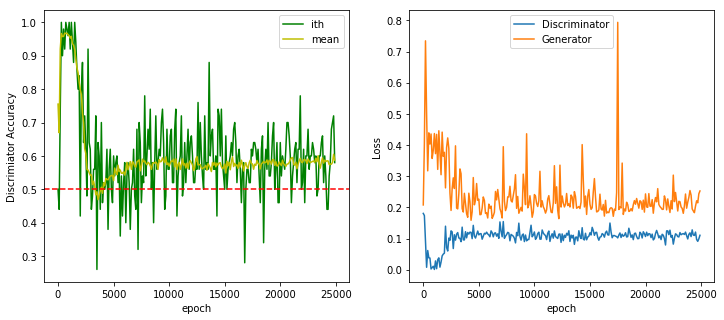

In [63]:
print('Adadelta optimizer. Loss = logcosh. Epoch = 25000')
plotGANprocess(gan_ada_logcosh, 100)

**Note: Use squared_hinge and binary_crossentropy will always give accuracy=0%.**

## Choose Adadelta Optimizer + MSE Loss

### Change batch size

### Batch size = 10

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.206781, acc.: 70.00%] [G loss: 0.282948]
1000 [D loss: 0.016179, acc.: 100.00%] [G loss: 1.111168]
2000 [D loss: 0.004940, acc.: 100.00%] [G loss: 1.055987]
3000 [D loss: 0.290262, acc.: 30.00%] [G loss: 1.199540]
4000 [D loss: 0.013998, acc.: 100.00%] [G loss: 0.667440]
5000 [D loss: 0.314081, acc.: 50.00%] [G loss: 0.840645]
6000 [D loss: 0.254276, acc.: 50.00%] [G loss: 0.604981]
7000 [D loss: 0.237639, acc.: 50.00%] [G loss: 0.795050]
8000 [D loss: 0.118234, acc.: 70.00%] [G loss: 0.452521]
9000 [D loss: 0.205746, acc.: 60.00%] [G loss: 0.434207]
10000 [D loss: 0.153966, acc.: 80.00%] [G loss: 0.632419]
11000 [D loss: 0.224983, acc.: 60.00%] [G loss: 0.529704]
12000 [D loss: 0.319224, acc.: 30.00%] [G loss: 0.324817]
13000 [D loss: 0.277031, acc.: 40.00%] [G loss: 0.452759]
14000 [D loss: 0.340171, acc.: 40.00%] [G loss: 0.739536]
15000 [D loss: 0.215607, acc.: 60.00%] [G loss: 0.325204]
16000 [D loss: 0.260181, acc.: 50.00%] [G loss: 0.392329]
17000 [D loss: 0.207535,

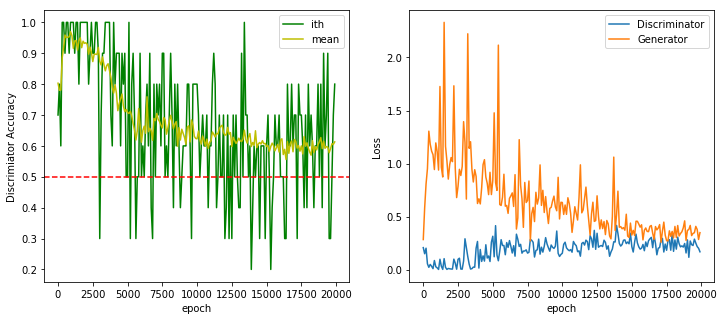

Wall time: 13min 42s


In [79]:
%%time
b=10
gan_ada_mse = LSGAN('adadelta', 'mse', False)   
gan_ada_mse.train(ssEDCs, epochs=20000, batch_size=b, sample_interval=500)
print('batch_size =', b)
plotGANprocess(gan_ada_mse, 100)

### Batch size = 20

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.006235, acc.: 100.00%] [G loss: 0.914491]
1000 [D loss: 0.019987, acc.: 95.00%] [G loss: 0.789230]
2000 [D loss: 0.221318, acc.: 75.00%] [G loss: 0.702171]
3000 [D loss: 0.231634, acc.: 60.00%] [G loss: 0.390983]
4000 [D loss: 0.261297, acc.: 55.00%] [G loss: 0.463750]
5000 [D loss: 0.220555, acc.: 70.00%] [G loss: 0.617384]
6000 [D loss: 0.206495, acc.: 55.00%] [G loss: 0.902539]
7000 [D loss: 0.235204, acc.: 45.00%] [G loss: 0.620641]
8000 [D loss: 0.262304, acc.: 50.00%] [G loss: 0.493826]
9000 [D loss: 0.216250, acc.: 65.00%] [G loss: 0.517086]
10000 [D loss: 0.206162, acc.: 70.00%] [G loss: 0.423345]
11000 [D loss: 0.234628, acc.: 55.00%] [G loss: 0.445279]
12000 [D loss: 0.220781, acc.: 60.00%] [G loss: 0.431375]
13000 [D loss: 0.158724, acc.: 80.00%] [G loss: 0.355890]
14000 [D loss: 0.214647, acc.: 60.00%] [G loss: 0.349309]
batch_size = 20


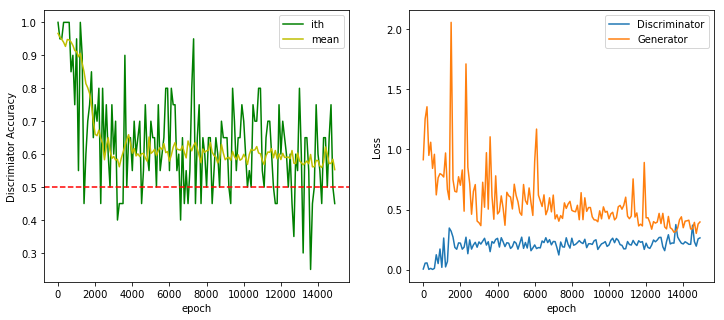

Wall time: 10min 53s


In [71]:
%%time
b=20
gan_ada_mse = LSGAN('adadelta', 'mse', False)   
gan_ada_mse.train(ssEDCs, epochs=15000, batch_size=b, sample_interval=500)
print('batch_size =', b)
plotGANprocess(gan_ada_mse, 100)

### Batch size = 50

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.320041, acc.: 48.00%] [G loss: 1.774044]
1000 [D loss: 0.091047, acc.: 98.00%] [G loss: 1.085139]
2000 [D loss: 0.203029, acc.: 76.00%] [G loss: 0.638520]
3000 [D loss: 0.226939, acc.: 50.00%] [G loss: 0.531473]
4000 [D loss: 0.247525, acc.: 58.00%] [G loss: 0.456145]
5000 [D loss: 0.185552, acc.: 80.00%] [G loss: 0.401628]
6000 [D loss: 0.227015, acc.: 64.00%] [G loss: 0.510859]
7000 [D loss: 0.240669, acc.: 64.00%] [G loss: 0.453707]
8000 [D loss: 0.246699, acc.: 42.00%] [G loss: 0.458676]
9000 [D loss: 0.242516, acc.: 46.00%] [G loss: 0.604856]
10000 [D loss: 0.211402, acc.: 58.00%] [G loss: 0.409287]
11000 [D loss: 0.261534, acc.: 52.00%] [G loss: 0.384320]
12000 [D loss: 0.192776, acc.: 66.00%] [G loss: 0.611561]
13000 [D loss: 0.250003, acc.: 50.00%] [G loss: 0.463124]
14000 [D loss: 0.159912, acc.: 78.00%] [G loss: 0.444109]
batch_size = 50


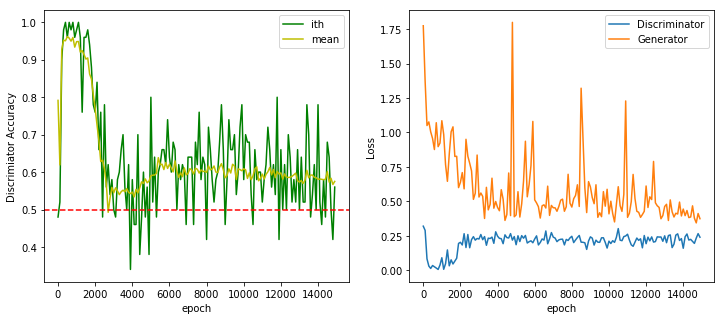

Wall time: 13min 42s


In [75]:
%%time
b=50
gan_ada_mse = LSGAN('adadelta', 'mse', False)   
gan_ada_mse.train(ssEDCs, epochs=15000, batch_size=b, sample_interval=500)
print('batch_size =', b)
plotGANprocess(gan_ada_mse, 100)

### Batch size = 120

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.994826, acc.: 47.50%] [G loss: 0.871385]
1000 [D loss: 0.016709, acc.: 99.17%] [G loss: 1.087862]
2000 [D loss: 0.201725, acc.: 69.17%] [G loss: 0.551391]
3000 [D loss: 0.235795, acc.: 55.83%] [G loss: 0.359827]
4000 [D loss: 0.248832, acc.: 55.00%] [G loss: 0.394568]
5000 [D loss: 0.239379, acc.: 51.67%] [G loss: 0.348553]
6000 [D loss: 0.287500, acc.: 40.83%] [G loss: 0.438356]
7000 [D loss: 0.245844, acc.: 50.83%] [G loss: 0.517637]
8000 [D loss: 0.254712, acc.: 43.33%] [G loss: 0.360294]
9000 [D loss: 0.233623, acc.: 61.67%] [G loss: 0.410318]
10000 [D loss: 0.240580, acc.: 51.67%] [G loss: 0.384546]
11000 [D loss: 0.242240, acc.: 54.17%] [G loss: 0.356222]
12000 [D loss: 0.246802, acc.: 55.00%] [G loss: 0.385664]
13000 [D loss: 0.228018, acc.: 56.67%] [G loss: 0.384504]
14000 [D loss: 0.217903, acc.: 58.33%] [G loss: 0.669394]
batch_size = 120


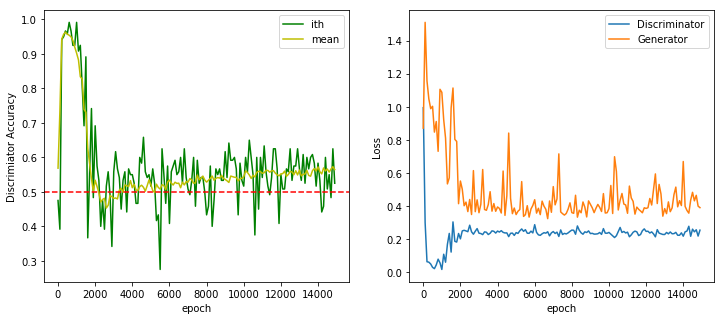

Wall time: 19min 17s


In [78]:
%%time
b=120
gan_ada_mse = LSGAN('adadelta', 'mse', False)
gan_ada_mse.train(ssEDCs, epochs=15000, batch_size=b, sample_interval=500)
print('batch_size =', b)
plotGANprocess(gan_ada_mse, 100)

### Change Generator number of layers

So far we are using G: input-->256-->512-->1024-->output.

**<font style='background-color: #feffc6'>Try flipping layer</font>: input-->256-->1024-->512-->output**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_220 (Dense)            (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_158 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_221 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_159 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_222 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.545336, acc.: 45.00%] [G loss: 0.701538]
1000 [D loss: 0.115774, acc.: 85.00%] [G loss: 0.658091]
2000 [D loss: 0.214900, acc.: 65.00%] [G loss: 0.561437]
3000 [D loss: 0.259791, acc.: 35.00%] [G loss: 0.422038]
4000 [D loss: 0.225946, acc.: 65.00%] [G loss: 0.370212]
5000 [D loss: 0.199770, acc.: 65.00%] [G loss: 0.390781]
6000 [D loss: 0.235408, acc.: 55.00%] [G loss: 0.367704]
7000 [D loss: 0.243790, acc.: 45.00%] [G loss: 0.455003]
8000 [D loss: 0.227715, acc.: 55.00%] [G loss: 0.331674]
9000 [D loss: 0.218897, acc.: 50.00%] [G loss: 0.395992]
10000 [D loss: 0.272886, acc.: 40.00%] [G loss: 0.328827]
11000 [D loss: 0.221988, acc.: 60.00%] [G loss: 0.344015]
12000 [D loss: 0.259131, acc.: 40.00%] [G loss: 0.455386]
13000 [D loss: 0.244480, acc.: 50.00%] [G loss: 0.338787]
14000 [D loss: 0.253299, acc.: 55.00%] [G loss: 0.388035]
batch_size = 20


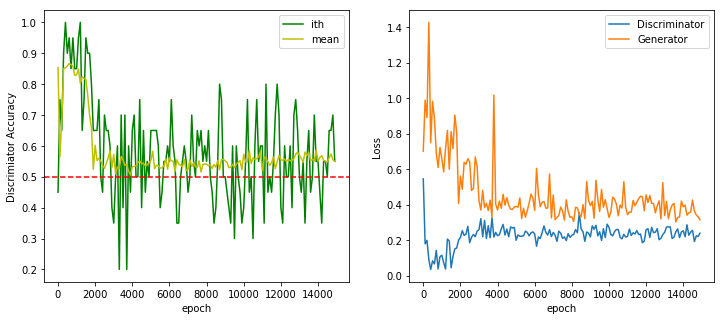

Wall time: 11min 48s


In [85]:
%%time
b=20
gan_ada_mse = LSGAN('adadelta', 'mse', True)
gan_ada_mse.train(ssEDCs, epochs=15000, batch_size=b, sample_interval=500)
print('batch_size =', b)
plotGANprocess(gan_ada_mse, 100)

**<font style='background-color: #feffc6'>Try flipping layer</font>: input-->1024-->512-->256-->output**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_258 (Dense)            (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_178 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_259 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_179 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_260 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.729447, acc.: 50.00%] [G loss: 1.408082]
1000 [D loss: 0.215399, acc.: 55.00%] [G loss: 0.696884]
2000 [D loss: 0.177167, acc.: 70.00%] [G loss: 0.465741]
3000 [D loss: 0.296875, acc.: 40.00%] [G loss: 0.341939]
4000 [D loss: 0.270218, acc.: 30.00%] [G loss: 0.379861]
5000 [D loss: 0.267246, acc.: 40.00%] [G loss: 0.410734]
6000 [D loss: 0.253653, acc.: 55.00%] [G loss: 0.284315]
7000 [D loss: 0.295971, acc.: 30.00%] [G loss: 0.345240]
8000 [D loss: 0.252051, acc.: 50.00%] [G loss: 0.342747]
9000 [D loss: 0.302719, acc.: 30.00%] [G loss: 0.351459]
10000 [D loss: 0.253416, acc.: 45.00%] [G loss: 0.314607]
11000 [D loss: 0.281420, acc.: 45.00%] [G loss: 0.324717]
12000 [D loss: 0.232075, acc.: 60.00%] [G loss: 0.312041]
13000 [D loss: 0.248142, acc.: 45.00%] [G loss: 0.350947]
14000 [D loss: 0.247022, acc.: 45.00%] [G loss: 0.317281]
batch_size = 20


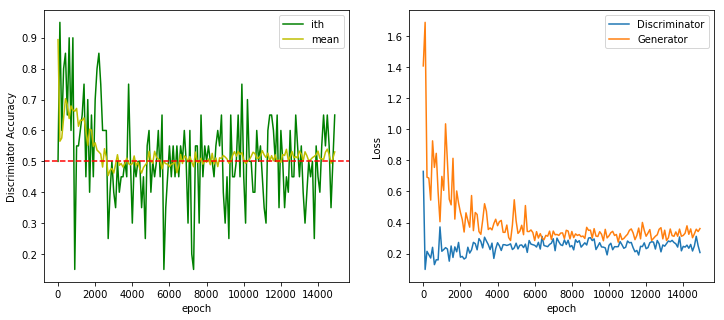

Wall time: 11min 8s


In [100]:
%%time
b=20
gan_ada_mse = LSGAN('adadelta', 'mse', True)
gan_ada_mse.train(ssEDCs, epochs=15000, batch_size=b, sample_interval=500)
print('batch_size =', b)
plotGANprocess(gan_ada_mse, 100)

**<font style='background-color: #feffc6'>Try adding layer</font>: input-->256-->512-->1024-->512-->output**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_147 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.494857, acc.: 50.00%] [G loss: 1.286792]
1000 [D loss: 0.189075, acc.: 70.00%] [G loss: 0.667430]
2000 [D loss: 0.379293, acc.: 30.00%] [G loss: 0.506028]
3000 [D loss: 0.236751, acc.: 30.00%] [G loss: 0.480470]
4000 [D loss: 0.237892, acc.: 40.00%] [G loss: 0.392809]
5000 [D loss: 0.229515, acc.: 65.00%] [G loss: 0.344896]
6000 [D loss: 0.246385, acc.: 30.00%] [G loss: 0.281775]
7000 [D loss: 0.231684, acc.: 45.00%] [G loss: 0.315235]
8000 [D loss: 0.242378, acc.: 40.00%] [G loss: 0.288508]
9000 [D loss: 0.234699, acc.: 60.00%] [G loss: 0.300673]
10000 [D loss: 0.272565, acc.: 25.00%] [G loss: 0.366940]
11000 [D loss: 0.282075, acc.: 45.00%] [G loss: 0.389105]
12000 [D loss: 0.232761, acc.: 50.00%] [G loss: 0.308113]
13000 [D loss: 0.250364, acc.: 45.00%] [G loss: 0.336825]
14000 [D loss: 0.250963, acc.: 45.00%] [G loss: 0.295619]
batch_size = 20


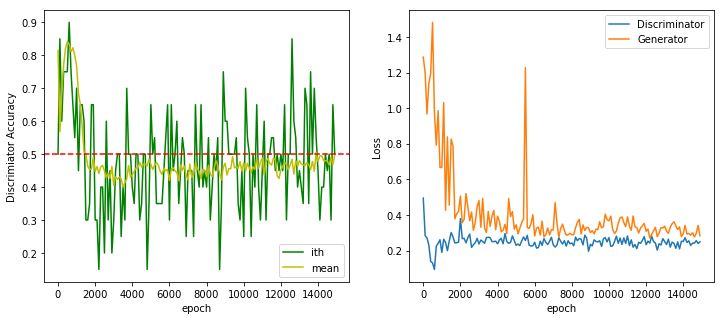

Wall time: 13min 32s


In [81]:
%%time
b=20
gan_ada_mse = LSGAN('adadelta', 'mse', True)
gan_ada_mse.train(ssEDCs, epochs=15000, batch_size=b, sample_interval=500)
print('batch_size =', b)
plotGANprocess(gan_ada_mse, 100)

**<font style='background-color: #feffc6'>Try adding layer</font>: input-->256-->512-->512-->512-->output**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_152 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_153 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.573808, acc.: 50.00%] [G loss: 0.705919]
1000 [D loss: 0.106032, acc.: 80.00%] [G loss: 0.528778]
2000 [D loss: 0.228453, acc.: 60.00%] [G loss: 0.484560]
3000 [D loss: 0.271644, acc.: 40.00%] [G loss: 0.486419]
4000 [D loss: 0.233784, acc.: 50.00%] [G loss: 0.459410]
5000 [D loss: 0.217856, acc.: 60.00%] [G loss: 0.350011]
6000 [D loss: 0.288468, acc.: 50.00%] [G loss: 0.384144]
7000 [D loss: 0.229390, acc.: 55.00%] [G loss: 0.376881]
8000 [D loss: 0.235195, acc.: 65.00%] [G loss: 0.375306]
9000 [D loss: 0.251232, acc.: 40.00%] [G loss: 0.364578]
10000 [D loss: 0.283554, acc.: 45.00%] [G loss: 0.324725]
11000 [D loss: 0.204159, acc.: 70.00%] [G loss: 0.404191]
12000 [D loss: 0.264880, acc.: 50.00%] [G loss: 0.350714]
13000 [D loss: 0.217646, acc.: 65.00%] [G loss: 0.316767]
14000 [D loss: 0.229133, acc.: 60.00%] [G loss: 0.356593]
batch_size = 20


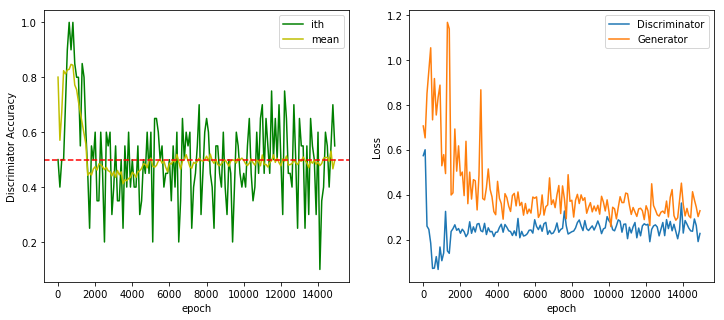

Wall time: 10min 6s


In [83]:
%%time
b=20
gan_ada_mse = LSGAN('adadelta', 'mse', True)
gan_ada_mse.train(ssEDCs, epochs=15000, batch_size=b, sample_interval=500)
plotGANprocess(gan_ada_mse, 100)

**<font style='background-color: #feffc6'>Try fewer layers</font>: input-->1024-->1024-->output**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_234 (Dense)            (None, 512)               128512    
_________________________________________________________________
leaky_re_lu_168 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_169 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_236 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.729931, acc.: 35.00%] [G loss: 1.058123]
1000 [D loss: 0.049444, acc.: 100.00%] [G loss: 1.211843]
2000 [D loss: 0.013031, acc.: 100.00%] [G loss: 1.043755]
3000 [D loss: 0.064952, acc.: 90.00%] [G loss: 0.770353]
4000 [D loss: 0.281899, acc.: 35.00%] [G loss: 0.540422]
5000 [D loss: 0.276601, acc.: 45.00%] [G loss: 0.953303]
6000 [D loss: 0.159942, acc.: 70.00%] [G loss: 0.408031]
7000 [D loss: 0.138062, acc.: 75.00%] [G loss: 0.537225]
8000 [D loss: 0.232700, acc.: 60.00%] [G loss: 0.556516]
9000 [D loss: 0.187761, acc.: 75.00%] [G loss: 0.452853]
10000 [D loss: 0.177112, acc.: 85.00%] [G loss: 0.483634]
11000 [D loss: 0.219599, acc.: 50.00%] [G loss: 0.633906]
12000 [D loss: 0.192399, acc.: 65.00%] [G loss: 0.473663]
13000 [D loss: 0.203934, acc.: 70.00%] [G loss: 0.345244]
14000 [D loss: 0.170477, acc.: 80.00%] [G loss: 0.397560]


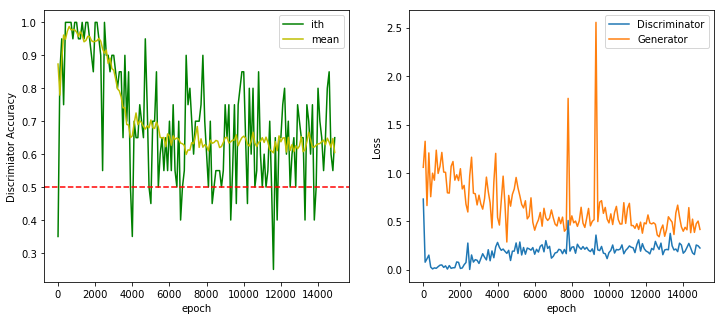

Wall time: 13min 47s


In [89]:
%%time
gan_ada_mse = LSGAN('adadelta', 'mse', True)
gan_ada_mse.train(ssEDCs, epochs=15000, batch_size=20, sample_interval=500)
plotGANprocess(gan_ada_mse, 100)

### Softmax

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_251 (Dense)            (None, 512)               128512    
_________________________________________________________________
softmax_2 (Softmax)          (None, 512)               0         
_________________________________________________________________
dense_252 (Dense)            (None, 256)               131328    
_________________________________________________________________
softmax_3 (Softmax)          (None, 256)               0         
_________________________________________________________________
dense_253 (Dense)            (None, 1)                 257       
Total params: 260,097
Trainable params: 260,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.496293, acc.: 50.00%] [G loss: 0.986912]
1000 [D loss: 0.252894, acc.: 0.00%] [G loss: 0.252909]
2000 [D loss: 0.253896, acc.: 0.00%] [G loss: 0.253927]
3000 [D loss: 0.254556, acc.: 0.00%] [G loss: 0.254604]
4000 [D loss: 0.255056, acc.: 0.00%] [G loss: 0.255125]
5000 [D loss: 0.255465, acc.: 0.00%] [G loss: 0.255562]
6000 [D loss: 0.255807, acc.: 0.00%] [G loss: 0.255954]
7000 [D loss: 0.255969, acc.: 0.00%] [G loss: 0.256409]
8000 [D loss: 0.258844, acc.: 0.00%] [G loss: 0.260663]
9000 [D loss: 0.258009, acc.: 0.00%] [G loss: 0.258576]
10000 [D loss: 0.257992, acc.: 0.00%] [G loss: 0.258374]
11000 [D loss: 0.258072, acc.: 0.00%] [G loss: 0.258366]
12000 [D loss: 0.258194, acc.: 0.00%] [G loss: 0.258428]
13000 [D loss: 0.258333, acc.: 0.00%] [G loss: 0.258518]
14000 [D loss: 0.258488, acc.: 0.00%] [G loss: 0.258639]


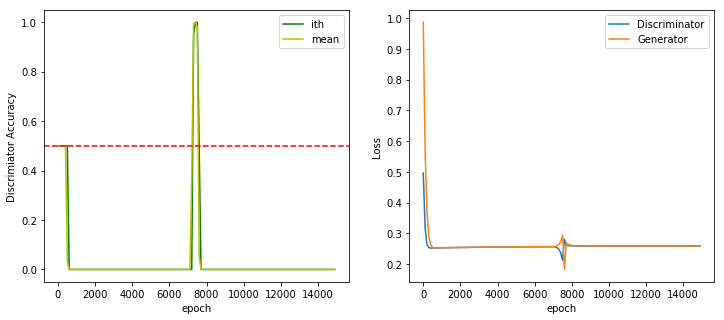

Wall time: 12min 14s


In [98]:
%%time
gan_ada_softmax = LSGAN('adadelta', 'mse', True)
gan_ada_softmax.train(ssEDCs, epochs=15000, batch_size=20, sample_interval=500)
plotGANprocess(gan_ada_softmax, 100)

## Discussion

### Optimizer: Adam

"Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. <font style='background-color: #feffc6'>Adam is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters.</font> The method is also appropriate for non-stationary objectives and problems with <font style='background-color: #feffc6'>very noisy and/or sparse gradients.</font> The hyper-parameters have intuitive interpretations and typically require little tuning."

ref: https://arxiv.org/abs/1412.6980v9


### Optimizer: Adadelta

"ADADELTA is a novel per-dimension learning rate method for gradient descent. Thie method dynamically adapts over time using only first order information and has minimal computational overhead beyond vanilla stochastic gradient descent. <font style='background-color: #feffc6'>The method requires no manual tuning of a learning rate and appears robust to noisy gradient information,</font> different model architecture choices, various data modalities and selection of hyperparameters."

ref: https://arxiv.org/abs/1212.5701

### Loss Function:

We are now using 'mse' as the loss function.

To Do:

1. How do people know they are overfitting while running GAN.
2. 